## Setup Environments

### Mount Drive and Setup Project Directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [42]:
project_dir="your-project-directory"

In [ ]:
%cd {project_dir}

In [ ]:
!pwd

### Define All Seed

In [45]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## MNIST Dataset

In [46]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt

In [47]:
# Create transform to resize (32, 32) and Normalize [-1, 1]
transform = transforms.Compose([
    transforms.Resize((32, 32)), # LeNet-5 ใช้ 32×32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # ทำให้ภาพอยู่ในช่วง [-1, 1]
])

In [48]:
# Load MNIST
train_val_dataset = MNIST(root="data", train=True, download=True, transform=transform)
test_dataset = MNIST(root="data", train=False, download=True, transform=transform)

In [49]:
# Split training / eval set (90% / 10%)
train_len = int(len(train_val_dataset) * 0.9)
eval_len = len(train_val_dataset) - train_len
train_dataset, eval_dataset = random_split(train_val_dataset, [train_len, eval_len])

### DataLoder

In [50]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
eval_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [51]:
def show_mnist_examples(dataset):
    plt.figure(figsize=(10, 2.5))
    for i in range(10):
        image, label = dataset[i]
        plt.subplot(1, 10, i + 1)
        plt.imshow(image.squeeze(0), cmap="gray")
        plt.title(str(label), fontsize=10)
        plt.axis("off")
    plt.suptitle(f"MNIST Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

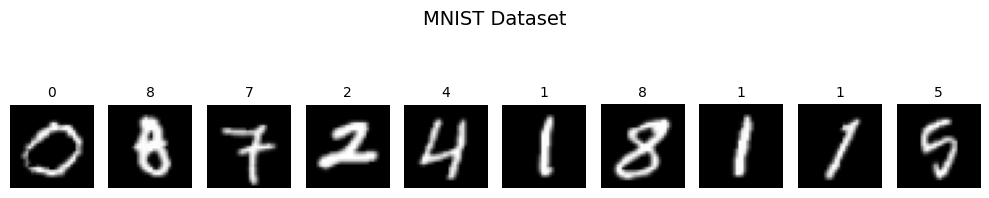

In [52]:
show_mnist_examples(train_dataset)

## LeNet-5

```
Input: [1x32x32] grayscale image
→ C1: Conv2D(6, 5x5)
→ S2: AvgPool(2x2)
→ C3: Conv2D(16, 5x5)
→ S4: AvgPool(2x2)
→ C5: Conv2D(120, 5x5)
→ Flatten
→ FC6: Linear(84)
→ Output: Linear(10) ← เราจะเปลี่ยนเป็น 101 class
```

###  LeNet5 Model

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        # Feature Extractor (Backbone)
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # gray scale input, 6 features
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # downsampling with average pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5) # 16 features
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # downsampling with average pooling
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5) # 120 features

        # Classifier (Fully Connected)
        self.fc1 = nn.Linear(120, 84) # 120 vectors to 84 neurons
        self.fc2 = nn.Linear(84, num_classes) # 84 neurons to 10 classes

    def forward(self, x):
        # input = [1, 32, 32]

        # Feature Extractor (Backbone)
        x = F.relu(self.conv1(x)) # Conv + ReLU
        x = self.pool1(x) # AvgPool
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x)) # Output: [batch, 120, 1, 1]

        # Classifier (Fully Connected)
        x = x.view(x.size(0), -1) # flatten เป็น [batch, 120]
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Output Size = ((Input - Kernel + (2 * Padding)) / Stride) + 1

```
Input size (เช่น 32)
Kernel size (เช่น 5)
Padding (เช่น 0)
Stride (ค่าเริ่มต้นคือ 1)
```

In [54]:
# Create a Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device) # move to GPU

In [55]:
!pip install -q torchsummary

#### Model Summary

In [56]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


## Training Loop

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time

In [58]:
# Loss และ Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
# Helper to Calculate Accuracy
def calculate_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

In [60]:
# Logging
train_losses, eval_losses = [], []
train_accuracies, eval_accuracies = [], []

In [61]:
# epochs
NUM_EPOCHS = 20

In [62]:
total_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    train_loop = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}]")
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Logging
        running_loss += loss.item() * inputs.size(0)
        running_correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

        train_loop.set_postfix(loss=loss.item())

    train_loss = running_loss / total
    train_acc = running_correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- EVAL ----
    model.eval()
    eval_loss = 0.0
    eval_correct = 0
    eval_total = 0

    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            eval_loss += loss.item() * inputs.size(0)
            eval_correct += (outputs.argmax(1) == labels).sum().item()
            eval_total += labels.size(0)

    eval_loss = eval_loss / eval_total
    eval_acc = eval_correct / eval_total
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_acc)

    end_time = time.time()
    print(f"Epoch {epoch+1} Summary | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Eval Loss: {eval_loss:.4f} | Eval Acc: {eval_acc:.4f} | Time: {end_time - start_time:.2f}s")

total_time = time.time() - total_start_time
print(f"\nFinish training on time: {total_time/60:.2f} Min.")

[Train Epoch 1]: 100%|██████████| 844/844 [00:08<00:00, 101.05it/s, loss=0.223]


Epoch 1 Summary | Train Loss: 0.3156 | Train Acc: 0.9009 | Eval Loss: 0.1190 | Eval Acc: 0.9607 | Time: 9.24s


[Train Epoch 2]: 100%|██████████| 844/844 [00:07<00:00, 109.12it/s, loss=0.105]


Epoch 2 Summary | Train Loss: 0.0893 | Train Acc: 0.9721 | Eval Loss: 0.0669 | Eval Acc: 0.9802 | Time: 8.68s


[Train Epoch 3]: 100%|██████████| 844/844 [00:07<00:00, 112.19it/s, loss=0.00981]


Epoch 3 Summary | Train Loss: 0.0626 | Train Acc: 0.9807 | Eval Loss: 0.0647 | Eval Acc: 0.9803 | Time: 8.36s


[Train Epoch 4]: 100%|██████████| 844/844 [00:07<00:00, 110.30it/s, loss=0.0374]


Epoch 4 Summary | Train Loss: 0.0494 | Train Acc: 0.9846 | Eval Loss: 0.0500 | Eval Acc: 0.9860 | Time: 8.46s


[Train Epoch 5]: 100%|██████████| 844/844 [00:07<00:00, 113.44it/s, loss=0.00555]


Epoch 5 Summary | Train Loss: 0.0414 | Train Acc: 0.9872 | Eval Loss: 0.0417 | Eval Acc: 0.9875 | Time: 8.44s


[Train Epoch 6]: 100%|██████████| 844/844 [00:07<00:00, 114.28it/s, loss=0.0811]


Epoch 6 Summary | Train Loss: 0.0358 | Train Acc: 0.9882 | Eval Loss: 0.0473 | Eval Acc: 0.9847 | Time: 8.22s


[Train Epoch 7]: 100%|██████████| 844/844 [00:07<00:00, 107.74it/s, loss=0.00509]


Epoch 7 Summary | Train Loss: 0.0295 | Train Acc: 0.9903 | Eval Loss: 0.0434 | Eval Acc: 0.9877 | Time: 8.67s


[Train Epoch 8]: 100%|██████████| 844/844 [00:07<00:00, 113.69it/s, loss=0.00766]


Epoch 8 Summary | Train Loss: 0.0265 | Train Acc: 0.9910 | Eval Loss: 0.0360 | Eval Acc: 0.9897 | Time: 8.34s


[Train Epoch 9]: 100%|██████████| 844/844 [00:07<00:00, 112.37it/s, loss=0.0988]


Epoch 9 Summary | Train Loss: 0.0225 | Train Acc: 0.9927 | Eval Loss: 0.0393 | Eval Acc: 0.9888 | Time: 8.36s


[Train Epoch 10]: 100%|██████████| 844/844 [00:07<00:00, 107.23it/s, loss=0.0167]


Epoch 10 Summary | Train Loss: 0.0196 | Train Acc: 0.9936 | Eval Loss: 0.0382 | Eval Acc: 0.9895 | Time: 9.12s


[Train Epoch 11]: 100%|██████████| 844/844 [00:08<00:00, 102.07it/s, loss=0.0137]


Epoch 11 Summary | Train Loss: 0.0186 | Train Acc: 0.9941 | Eval Loss: 0.0386 | Eval Acc: 0.9913 | Time: 9.12s


[Train Epoch 12]: 100%|██████████| 844/844 [00:07<00:00, 110.70it/s, loss=0.0581]


Epoch 12 Summary | Train Loss: 0.0161 | Train Acc: 0.9946 | Eval Loss: 0.0485 | Eval Acc: 0.9875 | Time: 8.45s


[Train Epoch 13]: 100%|██████████| 844/844 [00:07<00:00, 109.45it/s, loss=0.0378]


Epoch 13 Summary | Train Loss: 0.0153 | Train Acc: 0.9949 | Eval Loss: 0.0436 | Eval Acc: 0.9895 | Time: 8.54s


[Train Epoch 14]: 100%|██████████| 844/844 [00:07<00:00, 113.65it/s, loss=0.0505]


Epoch 14 Summary | Train Loss: 0.0133 | Train Acc: 0.9956 | Eval Loss: 0.0442 | Eval Acc: 0.9905 | Time: 8.24s


[Train Epoch 15]: 100%|██████████| 844/844 [00:07<00:00, 114.23it/s, loss=0.0476]


Epoch 15 Summary | Train Loss: 0.0114 | Train Acc: 0.9962 | Eval Loss: 0.0409 | Eval Acc: 0.9905 | Time: 8.25s


[Train Epoch 16]: 100%|██████████| 844/844 [00:07<00:00, 108.15it/s, loss=0.00129]


Epoch 16 Summary | Train Loss: 0.0122 | Train Acc: 0.9960 | Eval Loss: 0.0579 | Eval Acc: 0.9870 | Time: 8.73s


[Train Epoch 17]: 100%|██████████| 844/844 [00:07<00:00, 112.09it/s, loss=0.000709]


Epoch 17 Summary | Train Loss: 0.0098 | Train Acc: 0.9967 | Eval Loss: 0.0456 | Eval Acc: 0.9898 | Time: 8.36s


[Train Epoch 18]: 100%|██████████| 844/844 [00:07<00:00, 111.08it/s, loss=0.00248]


Epoch 18 Summary | Train Loss: 0.0105 | Train Acc: 0.9964 | Eval Loss: 0.0534 | Eval Acc: 0.9905 | Time: 8.53s


[Train Epoch 19]: 100%|██████████| 844/844 [00:07<00:00, 112.51it/s, loss=0.00268]


Epoch 19 Summary | Train Loss: 0.0088 | Train Acc: 0.9974 | Eval Loss: 0.0472 | Eval Acc: 0.9892 | Time: 8.37s


[Train Epoch 20]: 100%|██████████| 844/844 [00:07<00:00, 113.63it/s, loss=4.46e-6]


Epoch 20 Summary | Train Loss: 0.0076 | Train Acc: 0.9974 | Eval Loss: 0.0447 | Eval Acc: 0.9907 | Time: 8.25s

Finish training on time: 2.85 Min.


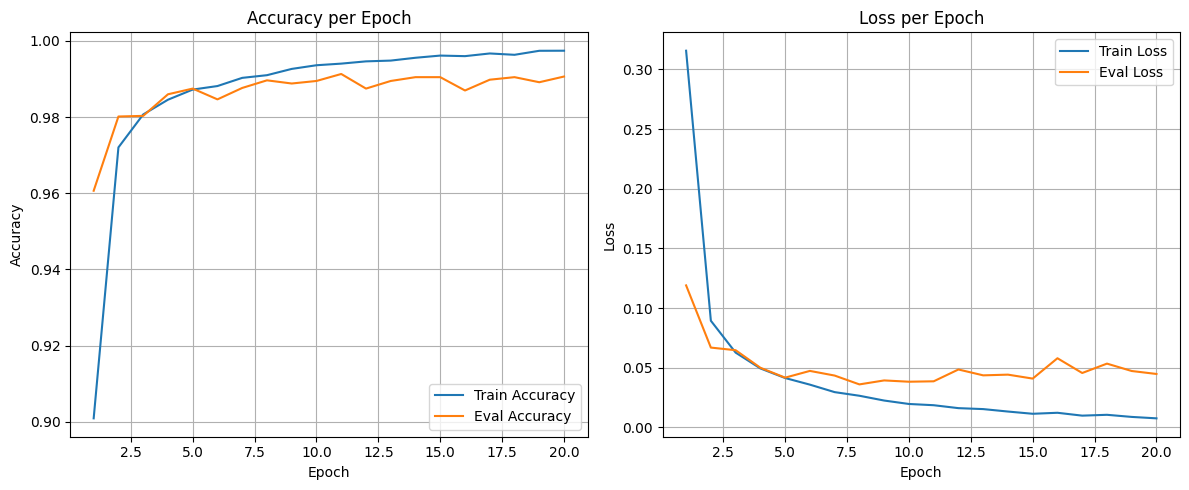

In [63]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, eval_accuracies, label='Eval Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, eval_losses, label='Eval Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Evaluate

In [64]:
import torch
import os
from sklearn.metrics import accuracy_score

In [65]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

Evaluating on Test Set: 100%|██████████| 157/157 [00:01<00:00, 112.52it/s]


In [66]:
test_accuracy = accuracy_score(all_targets, all_preds)
print(f"🎯 Final Test Accuracy: {test_accuracy:.4f}")

🎯 Final Test Accuracy: 0.9902


In [67]:
from sklearn.metrics import classification_report

print(classification_report(all_targets, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9928    0.9908    0.9918       980
           1     0.9921    0.9965    0.9943      1135
           2     0.9875    0.9932    0.9903      1032
           3     0.9882    0.9941    0.9911      1010
           4     0.9908    0.9908    0.9908       982
           5     0.9888    0.9877    0.9882       892
           6     0.9916    0.9843    0.9880       958
           7     0.9894    0.9942    0.9918      1028
           8     0.9938    0.9836    0.9886       974
           9     0.9871    0.9851    0.9861      1009

    accuracy                         0.9902     10000
   macro avg     0.9902    0.9900    0.9901     10000
weighted avg     0.9902    0.9902    0.9902     10000



## Confusion Matrix

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))

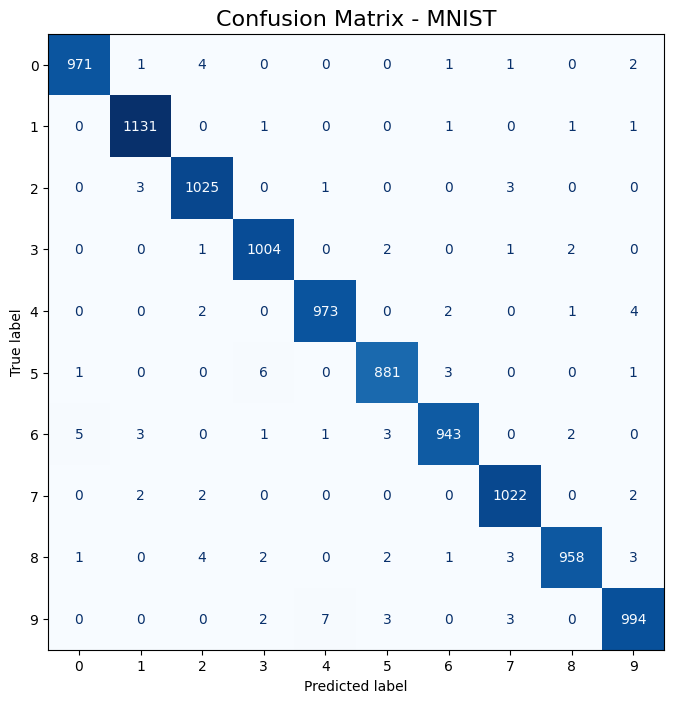

In [69]:
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - MNIST", fontsize=16)
plt.show()

## Random Inference

In [70]:
import random
import numpy as np

def infer_random_images(model, dataset, n=5):
    model.eval()
    plt.figure(figsize=(15, 3))
    for i in range(n):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            pred = output.argmax(dim=1).item()

        plt.subplot(1, n, i+1)
        plt.imshow(image.squeeze(0), cmap="gray")
        plt.title(f"GT: {label}\nPred: {pred}", fontsize=12, color='green' if pred == label else 'red')
        plt.axis("off")
    plt.suptitle("Inference", fontsize=16)
    plt.tight_layout()
    plt.show()

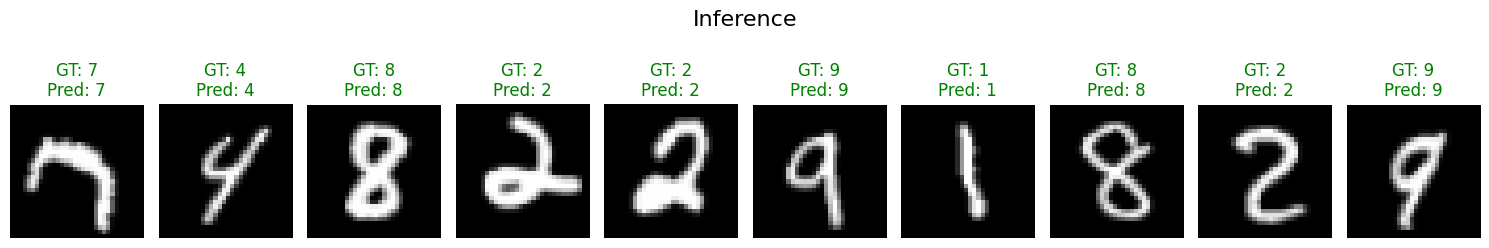

In [71]:
infer_random_images(model, test_dataset, n=10)

### Export Model

In [ ]:
!pwd

In [73]:

save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "lenet5_mnist.pt")
torch.save(model.state_dict(), model_path)
print(f"Model Saved at {model_path}")

Model Saved at saved_models/lenet5_mnist.pt


## Load Model

In [74]:
model = LeNet5(num_classes=10)
model.load_state_dict(torch.load(f"{project_dir}/saved_models/lenet5_mnist.pt"))

<All keys matched successfully>

In [75]:
model.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)